## NN with concrete numpy

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

### 1. generate data

In [2]:
def LR_slope(y):
    X = np.linspace(0,1,len(y))
    k,d = np.polyfit(X,y,1)
    
    return [k]

In [3]:
# synthetic training data
l = 50000  # data set length
N = 4     # number of inputs

X = np.array([np.random.uniform(0,1,N) for _ in range(l)])
Y = np.array([LR_slope(x) for x in X])

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

(45000, 4) (5000, 4)


### 2. define the model

In [5]:
class MyNet(torch.nn.Module):

    def __init__(self, input_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, 3)
        self.relu1 = nn.ReLU6()
        self.fc2 = nn.Linear(3, 3)
        self.relu2 = nn.ReLU6()
        self.fc3 = nn.Linear(3, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight)
                torch.nn.init.zeros_(m.bias)
 
        self.activations = {}
        self.track_activations = False

    def set_track_activations(self, enable):
        self.track_activations = enable
        if enable: #reset
            self.activations = {}
            for n, m in self.named_modules(): #in order traversal
                if isinstance(m, nn.Linear):
                    self.activations[n] = np.zeros( (0, m.weight.shape[0]), np.float32)
                    last_neurons = m.weight.shape[0]
                elif isinstance(m, nn.ReLU6):
                    self.activations[n] = np.zeros( (0, last_neurons), np.float32)

    def forward(self, x):        
        for n, m in self.named_children(): # in order traversal
            x = m(x)
            if self.track_activations:
                self.activations[n] = np.vstack( (self.activations[n], x.detach().numpy() ))

        return x

In [6]:
def train():
    for epoch in range(epochs):
        # Get a random batch of training data
        idx = torch.randperm(X_train.size()[0])
        X_batch = X_train[idx][:batch_size]
        y_batch = y_train[idx][:batch_size]

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()


        if (epoch+1) % 5000 == 0:
            # Print epoch number, loss
            print(f'Epoch: {epoch+1:5} | Loss: {loss.item():.9f}')
            if loss.item() < 1e-9:
                print("Training done")
                break

### 3. initialize and train model

In [8]:
# Initialize our model
model = MyNet(X.shape[1])

# Define our loss function
criterion = nn.MSELoss()

# Define our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Define the number of iterations
epochs = 40000

# Define the batch size
batch_size = 16

In [9]:
train()

Epoch:  5000 | Loss: 0.000000006
Epoch: 10000 | Loss: 0.000000035
Epoch: 15000 | Loss: 0.000000007
Epoch: 20000 | Loss: 0.000000000
Training done


In [11]:
y_pred = model(X_test)
print(f"mean error: {(y_pred - y_test).abs().mean()}")

mean error: 7.791488314978778e-06


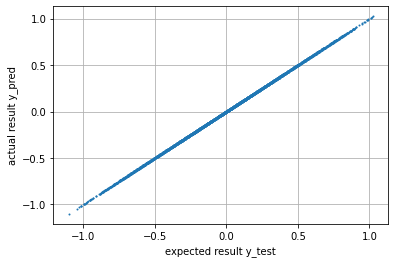

In [12]:
y_test_numpy = y_test.numpy()
plt.plot(y_test_numpy, y_pred.cpu().detach().numpy(), "o", markersize=1)
plt.grid()

plt.xlabel("expected result y_test")
plt.ylabel("actual result y_pred")

plt.show()

### 4. fp32 histograms

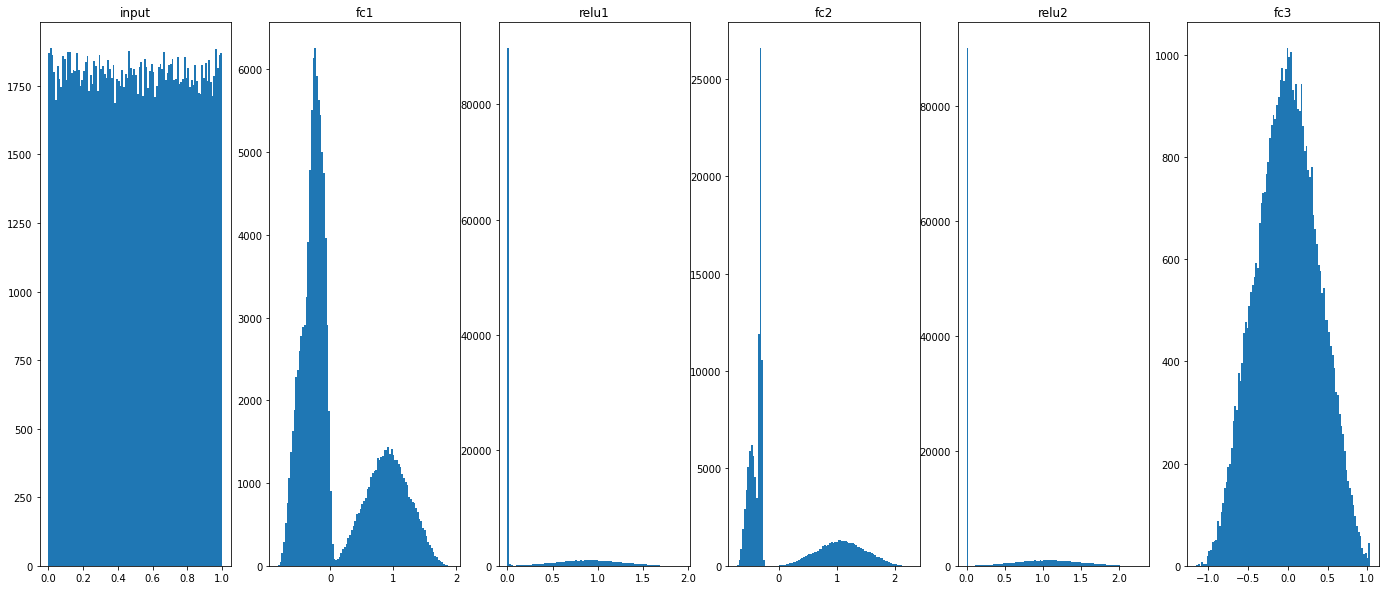

<Figure size 432x288 with 0 Axes>

In [48]:
X_eval = X_train.numpy()
#X_eval = X_test.numpy()
n_batches = X_eval.shape[0] // batch_size

model.eval()
model.set_track_activations(True)
for bi in range(n_batches):
    data = torch.from_numpy(X_eval[bi*batch_size:(bi+1)*batch_size, :].astype(np.float32))
    model(data)
model.set_track_activations(False)

_, ax = plt.subplots(1,6,figsize=(24,10))
ax[0].hist(X_eval.flatten(), 100)
ax[0].set_title("input")
for idx, key in enumerate(model.activations):
    ax[idx+1].hist(model.activations[key].flatten(), 100)
    ax[idx+1].set_title(key)
plt.show()
plt.savefig("distrib_w_fp32.png")

### 4. concrete quantization

In [49]:
from concrete.quantization import QuantizedArray, PostTrainingAffineQuantization
from concrete.torch import NumpyModule

 # Create corresponding numpy model
numpy_model = NumpyModule(model)

# Quantize with post-training static method, to have a model with integer weights
post_training_quant = PostTrainingAffineQuantization(3, numpy_model, is_signed=True)
quantized_module = post_training_quant.quantize_module(X_eval)

# Quantize input
q_x = QuantizedArray(3, X_eval)
q_input = q_x

q_act = {}
for layer_name, layer in quantized_module.quant_layers_dict.items():
    q_x = layer(q_x)
    q_act[layer_name] = q_x

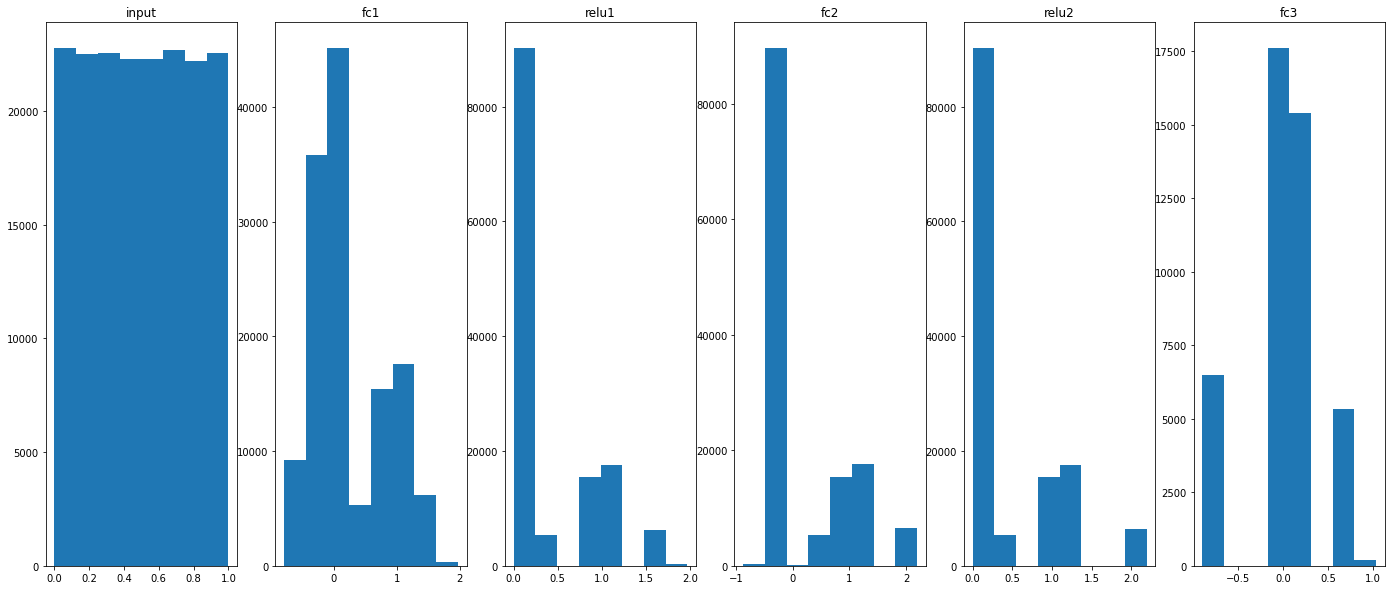

In [50]:
_, ax = plt.subplots(1,6,figsize=(24,10))
ax[0].hist(q_input.values.flatten(), 8)
ax[0].set_title("input")
for idx, key in enumerate(q_act):
    ax[idx+1].hist(q_act[key].values.flatten(), 8)
    ax[idx+1].set_title(key)
plt.savefig("distrib_w_int3.png")